# Multiclass Support Vector Machine exercise

*Complete and hand in this completed worksheet (including its outputs and any supporting code outside of the worksheet) with your assignment submission. For more details see the [assignments page](http://vision.stanford.edu/teaching/cs231n/assignments.html) on the course website.*

In this exercise you will:
    
- implement a fully-vectorized **loss function** for the SVM
- implement the fully-vectorized expression for its **analytic gradient**
- **check your implementation** using numerical gradient
- use a validation set to **tune the learning rate and regularization** strength
- **optimize** the loss function with **SGD**
- **visualize** the final learned weights


In [2]:
# Run some setup code for this notebook.

from __future__ import print_function

import random
import numpy as np
from cs231n.data_utils import load_CIFAR10
import matplotlib.pyplot as plt



# This is a bit of magic to make matplotlib figures appear inline in the
# notebook rather than in a new window.
%matplotlib inline
plt.rcParams['figure.figsize'] = (10.0, 8.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

# Some more magic so that the notebook will reload external python modules;
# see http://stackoverflow.com/questions/1907993/autoreload-of-modules-in-ipython
%load_ext autoreload
%autoreload 2

## CIFAR-10 Data Loading and Preprocessing

In [3]:
# Load the raw CIFAR-10 data.
cifar10_dir = 'cs231n/datasets/cifar-10-batches-py'
X_train, y_train, X_test, y_test = load_CIFAR10(cifar10_dir)

# As a sanity check, we print out the size of the training and test data.
print('Training data shape: ', X_train.shape)
print('Training labels shape: ', y_train.shape)
print('Test data shape: ', X_test.shape)
print('Test labels shape: ', y_test.shape)

Training data shape:  (50000, 32, 32, 3)
Training labels shape:  (50000,)
Test data shape:  (10000, 32, 32, 3)
Test labels shape:  (10000,)


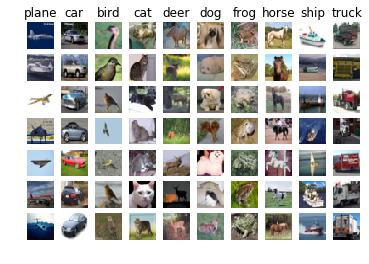

In [4]:
# Visualize some examples from the dataset.
# We show a few examples of training images from each class.
classes = ['plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
num_classes = len(classes)
samples_per_class = 7
for y, cls in enumerate(classes):
    idxs = np.flatnonzero(y_train == y)
    idxs = np.random.choice(idxs, samples_per_class, replace=False)
    for i, idx in enumerate(idxs):
        plt_idx = i * num_classes + y + 1
        plt.subplot(samples_per_class, num_classes, plt_idx)
        plt.imshow(X_train[idx].astype('uint8'))
        plt.axis('off')
        if i == 0:
            plt.title(cls)
plt.show()

In [5]:
# Split the data into train, val, and test sets. In addition we will
# create a small development set as a subset of the training data;
# we can use this for development so our code runs faster.
num_training = 49000
num_validation = 1000
num_test = 1000
num_dev = 500

# Our validation set will be num_validation points from the original
# training set.
mask = range(num_training, num_training + num_validation)
X_val = X_train[mask]
y_val = y_train[mask]

# Our training set will be the first num_train points from the original
# training set.
mask = range(num_training)
X_train = X_train[mask]
y_train = y_train[mask]

# We will also make a development set, which is a small subset of
# the training set.
mask = np.random.choice(num_training, num_dev, replace=False)
X_dev = X_train[mask]
y_dev = y_train[mask]

# We use the first num_test points of the original test set as our
# test set.
mask = range(num_test)
X_test = X_test[mask]
y_test = y_test[mask]

print('Train data shape: ', X_train.shape)
print('Train labels shape: ', y_train.shape)
print('Validation data shape: ', X_val.shape)
print('Validation labels shape: ', y_val.shape)
print('Test data shape: ', X_test.shape)
print('Test labels shape: ', y_test.shape)

Train data shape:  (49000, 32, 32, 3)
Train labels shape:  (49000,)
Validation data shape:  (1000, 32, 32, 3)
Validation labels shape:  (1000,)
Test data shape:  (1000, 32, 32, 3)
Test labels shape:  (1000,)


In [6]:
# Preprocessing: reshape the image data into rows
X_train = np.reshape(X_train, (X_train.shape[0], -1))
X_val = np.reshape(X_val, (X_val.shape[0], -1))
X_test = np.reshape(X_test, (X_test.shape[0], -1))
X_dev = np.reshape(X_dev, (X_dev.shape[0], -1))

# As a sanity check, print out the shapes of the data
print('Training data shape: ', X_train.shape)
print('Validation data shape: ', X_val.shape)
print('Test data shape: ', X_test.shape)
print('dev data shape: ', X_dev.shape)

Training data shape:  (49000, 3072)
Validation data shape:  (1000, 3072)
Test data shape:  (1000, 3072)
dev data shape:  (500, 3072)


[130.64189796 135.98173469 132.47391837 130.05569388 135.34804082
 131.75402041 130.96055102 136.14328571 132.47636735 131.48467347]


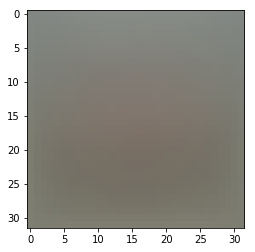

In [8]:
# Preprocessing: subtract the mean image
# first: compute the image mean based on the training data
mean_image = np.mean(X_train, axis=0)
print(mean_image[:10]) # print a few of the elements
plt.figure(figsize=(4,4))
plt.imshow(mean_image.reshape((32,32,3)).astype('uint8')) # visualize the mean image
plt.show()

In [9]:
# second: subtract the mean image from train and test data
X_train -= mean_image
X_val -= mean_image
X_test -= mean_image
X_dev -= mean_image

In [10]:
# third: append the bias dimension of ones (i.e. bias trick) so that our SVM
# only has to worry about optimizing a single weight matrix W.
X_train = np.hstack([X_train, np.ones((X_train.shape[0], 1))])
X_val = np.hstack([X_val, np.ones((X_val.shape[0], 1))])
X_test = np.hstack([X_test, np.ones((X_test.shape[0], 1))])
X_dev = np.hstack([X_dev, np.ones((X_dev.shape[0], 1))])

print(X_train.shape, X_val.shape, X_test.shape, X_dev.shape)

(49000, 3073) (1000, 3073) (1000, 3073) (500, 3073)


## SVM Classifier

Your code for this section will all be written inside **cs231n/classifiers/linear_svm.py**. 

As you can see, we have prefilled the function `compute_loss_naive` which uses for loops to evaluate the multiclass SVM loss function. 

In [12]:
# Evaluate the naive implementation of the loss we provided for you:
from cs231n.classifiers.linear_svm import svm_loss_naive
import time

# generate a random SVM weight matrix of small numbers
W = np.random.randn(3073, 10) * 0.0001 

loss, grad = svm_loss_naive(W, X_dev, y_dev, 0.000005)
print('loss: %f:'% (loss)) 

loss: 8.844312:


The `grad` returned from the function above is right now all zero. Derive and implement the gradient for the SVM cost function and implement it inline inside the function `svm_loss_naive`. You will find it helpful to interleave your new code inside the existing function.

To check that you have correctly implemented the gradient correctly, you can numerically estimate the gradient of the loss function and compare the numeric estimate to the gradient that you computed. We have provided code that does this for you:

In [16]:
# Once you've implemented the gradient, recompute it with the code below
# and gradient check it with the function we provided for you

# Compute the loss and its gradient at W.
loss, grad = svm_loss_naive(W, X_dev, y_dev, 0.0)

# Numerically compute the gradient along several randomly chosen dimensions, and
# compare them with your analytically computed gradient. The numbers should match
# almost exactly along all dimensions.
from cs231n.gradient_check import grad_check_sparse
f = lambda w: svm_loss_naive(w, X_dev, y_dev, 0.0)[0]
grad_numerical = grad_check_sparse(f, W, grad)

# do the gradient check once again with regularization turned on
# you didn't forget the regularization gradient did you?
loss, grad = svm_loss_naive(W, X_dev, y_dev, 5e1)
f = lambda w: svm_loss_naive(w, X_dev, y_dev, 5e1)[0]
grad_numerical = grad_check_sparse(f, W, grad)

numerical: 41.624848 analytic: 41.624848, relative error: 2.022046e-12
numerical: -5.636443 analytic: -5.636443, relative error: 4.717014e-12
numerical: 13.716899 analytic: 13.716899, relative error: 8.380744e-12
numerical: 28.425829 analytic: 28.425829, relative error: 9.354894e-14
numerical: 16.696756 analytic: 16.696756, relative error: 7.314692e-12
numerical: -8.271731 analytic: -8.271731, relative error: 3.732296e-11
numerical: -6.832773 analytic: -6.749700, relative error: 6.116182e-03
numerical: -16.555839 analytic: -16.555839, relative error: 2.590807e-11
numerical: 11.975262 analytic: 11.975262, relative error: 1.741741e-11
numerical: 19.212896 analytic: 19.212896, relative error: 2.572075e-11
numerical: 10.727089 analytic: 10.738508, relative error: 5.319748e-04
numerical: -3.792124 analytic: -3.793602, relative error: 1.947566e-04
numerical: 16.744999 analytic: 16.735221, relative error: 2.920286e-04
numerical: 10.068960 analytic: 10.058178, relative error: 5.357180e-04
nume

### Inline Question 1:
It is possible that once in a while a dimension in the gradcheck will not match exactly. What could such a discrepancy be caused by? Is it a reason for concern? What is a simple example in one dimension where a gradient check could fail? *Hint: the SVM loss function is not strictly speaking differentiable*

**Your Answer:** *fill this in.*

In [17]:
# Next implement the function svm_loss_vectorized; for now only compute the loss;
# we will implement the gradient in a moment.
tic = time.time()
loss_naive, grad_naive = svm_loss_naive(W, X_dev, y_dev, 0.000005)
toc = time.time()
print('Naive loss: %e computed in %fs' % (loss_naive, toc - tic))

from cs231n.classifiers.linear_svm import svm_loss_vectorized
tic = time.time()
loss_vectorized, _ = svm_loss_vectorized(W, X_dev, y_dev, 0.000005)
toc = time.time()
print('Vectorized loss: %e computed in %fs' % (loss_vectorized, toc - tic))

# The losses should match but your vectorized implementation should be much faster.
print('difference: %f' % (loss_naive - loss_vectorized))

Naive loss: 8.844312e+00 computed in 0.240312s
Vectorized loss: 8.844312e+00 computed in 0.090246s
difference: 0.000000


In [18]:
# Complete the implementation of svm_loss_vectorized, and compute the gradient
# of the loss function in a vectorized way.

# The naive implementation and the vectorized implementation should match, but
# the vectorized version should still be much faster.
tic = time.time()
_, grad_naive = svm_loss_naive(W, X_dev, y_dev, 0.000005)
toc = time.time()
print('Naive loss and gradient: computed in %fs' % (toc - tic))

tic = time.time()
_, grad_vectorized = svm_loss_vectorized(W, X_dev, y_dev, 0.000005)
toc = time.time()
print('Vectorized loss and gradient: computed in %fs' % (toc - tic))

# The loss is a single number, so it is easy to compare the values computed
# by the two implementations. The gradient on the other hand is a matrix, so
# we use the Frobenius norm to compare them.
difference = np.linalg.norm(grad_naive - grad_vectorized, ord='fro')
print('difference: %f' % difference)

Naive loss and gradient: computed in 0.264248s
Vectorized loss and gradient: computed in 0.003991s
difference: 0.000000


### Stochastic Gradient Descent

We now have vectorized and efficient expressions for the loss, the gradient and our gradient matches the numerical gradient. We are therefore ready to do SGD to minimize the loss.

In [19]:
# In the file linear_classifier.py, implement SGD in the function
# LinearClassifier.train() and then run it with the code below.
from cs231n.classifiers import LinearSVM
svm = LinearSVM()
tic = time.time()
loss_hist = svm.train(X_train, y_train, learning_rate=1e-7, reg=2.5e4,
                      num_iters=1500, verbose=True)
toc = time.time()
print('That took %fs' % (toc - tic))

iteration 0 / 1500: loss 794.912602
iteration 100 / 1500: loss 471.932925
iteration 200 / 1500: loss 285.773552
iteration 300 / 1500: loss 175.782549
iteration 400 / 1500: loss 106.461193
iteration 500 / 1500: loss 66.916582
iteration 600 / 1500: loss 42.161036
iteration 700 / 1500: loss 27.415889
iteration 800 / 1500: loss 18.655598
iteration 900 / 1500: loss 13.636124
iteration 1000 / 1500: loss 10.086908
iteration 1100 / 1500: loss 9.052434
iteration 1200 / 1500: loss 7.295533
iteration 1300 / 1500: loss 6.807072
iteration 1400 / 1500: loss 5.895185
That took 11.288578s


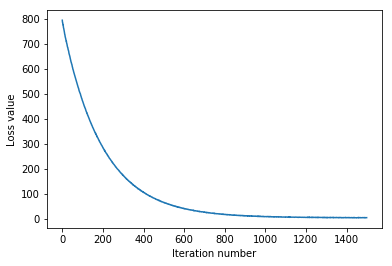

In [20]:
# A useful debugging strategy is to plot the loss as a function of
# iteration number:
plt.plot(loss_hist)
plt.xlabel('Iteration number')
plt.ylabel('Loss value')
plt.show()

In [21]:
# Write the LinearSVM.predict function and evaluate the performance on both the
# training and validation set
y_train_pred = svm.predict(X_train)
print('training accuracy: %f' % (np.mean(y_train == y_train_pred), ))
y_val_pred = svm.predict(X_val)
print('validation accuracy: %f' % (np.mean(y_val == y_val_pred), ))

training accuracy: 0.377571
validation accuracy: 0.381000


In [22]:
# Use the validation set to tune hyperparameters (regularization strength and
# learning rate). You should experiment with different ranges for the learning
# rates and regularization strengths; if you are careful you should be able to
# get a classification accuracy of about 0.4 on the validation set.
learning_rates = [1e-7, 5e-5]
regularization_strengths = [2.5e4, 5e4]

# results is dictionary mapping tuples of the form
# (learning_rate, regularization_strength) to tuples of the form
# (training_accuracy, validation_accuracy). The accuracy is simply the fraction
# of data points that are correctly classified.
results = {}
best_val = -1   # The highest validation accuracy that we have seen so far.
best_svm = None # The LinearSVM object that achieved the highest validation rate.

################################################################################
# TODO:                                                                        #
# Write code that chooses the best hyperparameters by tuning on the validation #
# set. For each combination of hyperparameters, train a linear SVM on the      #
# training set, compute its accuracy on the training and validation sets, and  #
# store these numbers in the results dictionary. In addition, store the best   #
# validation accuracy in best_val and the LinearSVM object that achieves this  #
# accuracy in best_svm.                                                        #
#                                                                              #
# Hint: You should use a small value for num_iters as you develop your         #
# validation code so that the SVMs don't take much time to train; once you are #
# confident that your validation code works, you should rerun the validation   #
# code with a larger value for num_iters.                                      #
################################################################################
from cs231n.classifiers import LinearSVM

for lr in np.linspace(learning_rates[0],learning_rates[1],5):
    for reg in np.linspace(regularization_strengths[0],regularization_strengths[1],5):
        svm = LinearSVM()
        tic = time.time()
        svm.train(X_train, y_train, learning_rate=lr, reg=reg,
                      num_iters=1500, verbose=True)
        toc = time.time()
        print('That tooks %fs'%(toc - tic))
        y_train_pred = svm.predict(X_train)
        print('training accuracy: %f' % (np.mean(y_train == y_train_pred), ))
        y_val_pred = svm.predict(X_val)
        print('validation accuracy: %f' % (np.mean(y_val == y_val_pred), ))
        results[(lr,reg)] = (np.mean(y_train == y_train_pred),np.mean(y_val == y_val_pred))
        
pass
################################################################################
#                              END OF YOUR CODE                                #
################################################################################
    
# Print out results.
for lr, reg in sorted(results):
    train_accuracy, val_accuracy = results[(lr, reg)]
    print('lr %e reg %e train accuracy: %f val accuracy: %f' % (
                lr, reg, train_accuracy, val_accuracy))
best_val = 0.391000

print('best validation accuracy achieved during cross-validation: %f' % best_val)

iteration 0 / 1500: loss 782.651812
iteration 100 / 1500: loss 466.798010
iteration 200 / 1500: loss 282.386830
iteration 300 / 1500: loss 172.573022
iteration 400 / 1500: loss 106.181538
iteration 500 / 1500: loss 65.964474
iteration 600 / 1500: loss 42.184809
iteration 700 / 1500: loss 27.856136
iteration 800 / 1500: loss 18.233164
iteration 900 / 1500: loss 13.143835
iteration 1000 / 1500: loss 9.735663
iteration 1100 / 1500: loss 8.266389
iteration 1200 / 1500: loss 7.414656
iteration 1300 / 1500: loss 6.789249
iteration 1400 / 1500: loss 6.610263
That tooks 10.790148s
training accuracy: 0.380633
validation accuracy: 0.387000
iteration 0 / 1500: loss 985.362799
iteration 100 / 1500: loss 520.327675
iteration 200 / 1500: loss 278.637892
iteration 300 / 1500: loss 150.177721
iteration 400 / 1500: loss 82.424853
iteration 500 / 1500: loss 45.907782
iteration 600 / 1500: loss 27.929151
iteration 700 / 1500: loss 16.942863
iteration 800 / 1500: loss 11.187404
iteration 900 / 1500: loss 

iteration 1300 / 1500: loss 386.462847
iteration 1400 / 1500: loss 370.740746
That tooks 10.819065s
training accuracy: 0.143224
validation accuracy: 0.133000
iteration 0 / 1500: loss 1353.152940
iteration 100 / 1500: loss 580.598935
iteration 200 / 1500: loss 483.626222
iteration 300 / 1500: loss 510.266662
iteration 400 / 1500: loss 464.731203
iteration 500 / 1500: loss 403.648709
iteration 600 / 1500: loss 595.619060
iteration 700 / 1500: loss 446.815044
iteration 800 / 1500: loss 498.995763
iteration 900 / 1500: loss 464.500018
iteration 1000 / 1500: loss 504.560086
iteration 1100 / 1500: loss 472.870266
iteration 1200 / 1500: loss 539.415381
iteration 1300 / 1500: loss 398.527204
iteration 1400 / 1500: loss 536.462881
That tooks 10.663483s
training accuracy: 0.159082
validation accuracy: 0.153000
iteration 0 / 1500: loss 1551.756135
iteration 100 / 1500: loss 744.678667
iteration 200 / 1500: loss 777.540128
iteration 300 / 1500: loss 781.341615
iteration 400 / 1500: loss 860.689753

iteration 1200 / 1500: loss 3365911679478260127299244103650336104227991737177089227126738327569789361121556130229373594855522798366680235839535669755289372695244029628621927291605423613231004117610496304221257728.000000
iteration 1300 / 1500: loss 2843324160743084717578768617771594936125509150066588481926564445212303176140848611881607439481576849209850824824038787638695258778234520350479768143863906770327520350507828309649967454001918317166592.000000
iteration 1400 / 1500: loss 2401872970213679679030502840699030104145146256835125024876471758644246943723111603268923224369292021390487969691392567173253655265411500359092867191151979881038510374958735259365998046322492923956075075755598413824.000000
That tooks 10.807019s
training accuracy: 0.087490
validation accuracy: 0.109000
iteration 0 / 1500: loss 1562.109309
iteration 100 / 1500: loss 928357288172606162911344074088339472384.000000
iteration 200 / 1500: loss 153450024594587144841958357695155589890164229133022904346827148656109420544.0

E:\myrepo\CS-MakeUp\cs231\assignment1\cs231n\classifiers\linear_svm.py:93: RuntimeWarning: overflow encountered in double_scalars
  loss += reg*np.sum(W*W)  # 这里我没有×系数0.5
D:\ProgramData\Anaconda3\envs\tf-gpu\lib\site-packages\numpy\core\fromnumeric.py:83: RuntimeWarning: overflow encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)
E:\myrepo\CS-MakeUp\cs231\assignment1\cs231n\classifiers\linear_svm.py:93: RuntimeWarning: overflow encountered in multiply
  loss += reg*np.sum(W*W)  # 这里我没有×系数0.5


iteration 900 / 1500: loss inf
iteration 1000 / 1500: loss inf
iteration 1100 / 1500: loss inf
iteration 1200 / 1500: loss inf
iteration 1300 / 1500: loss inf
iteration 1400 / 1500: loss inf
That tooks 11.470806s
training accuracy: 0.056429
validation accuracy: 0.064000
lr 1.000000e-07 reg 2.500000e+04 train accuracy: 0.380633 val accuracy: 0.387000
lr 1.000000e-07 reg 3.125000e+04 train accuracy: 0.374020 val accuracy: 0.370000
lr 1.000000e-07 reg 3.750000e+04 train accuracy: 0.377959 val accuracy: 0.397000
lr 1.000000e-07 reg 4.375000e+04 train accuracy: 0.373898 val accuracy: 0.385000
lr 1.000000e-07 reg 5.000000e+04 train accuracy: 0.368082 val accuracy: 0.384000
lr 1.257500e-05 reg 2.500000e+04 train accuracy: 0.182755 val accuracy: 0.183000
lr 1.257500e-05 reg 3.125000e+04 train accuracy: 0.181837 val accuracy: 0.179000
lr 1.257500e-05 reg 3.750000e+04 train accuracy: 0.171143 val accuracy: 0.187000
lr 1.257500e-05 reg 4.375000e+04 train accuracy: 0.157755 val accuracy: 0.146000


In [64]:
        svm = LinearSVM()
        tic = time.time()
        svm.train(X_train, y_train, learning_rate=1e-7, reg=2.5e4,
                      num_iters=1500, verbose=True)
        toc = time.time()
        print('That tooks %fs'%(toc - tic))
        y_train_pred = svm.predict(X_train)
        print('training accuracy: %f' % (np.mean(y_train == y_train_pred), ))
        y_val_pred = svm.predict(X_val)
        print('validation accuracy: %f' % (np.mean(y_val == y_val_pred), ))
        best_svm = svm

iteration 0 / 1500: loss 789.053417
iteration 100 / 1500: loss 470.691186
iteration 200 / 1500: loss 285.611140
iteration 300 / 1500: loss 174.666158
iteration 400 / 1500: loss 107.574496
iteration 500 / 1500: loss 66.522212
iteration 600 / 1500: loss 42.408536
iteration 700 / 1500: loss 27.722783
iteration 800 / 1500: loss 18.755048
iteration 900 / 1500: loss 13.821338
iteration 1000 / 1500: loss 9.909201
iteration 1100 / 1500: loss 8.469094
iteration 1200 / 1500: loss 7.491710
iteration 1300 / 1500: loss 6.743580
iteration 1400 / 1500: loss 5.816258
That tooks 5.398499s
training accuracy: 0.377714
validation accuracy: 0.381000


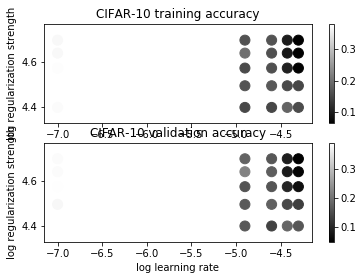

In [65]:
# Visualize the cross-validation results
import math
x_scatter = [math.log10(x[0]) for x in results]
y_scatter = [math.log10(x[1]) for x in results]

# plot training accuracy
marker_size = 100
colors = [results[x][0] for x in results]
plt.subplot(2, 1, 1)
plt.scatter(x_scatter, y_scatter, marker_size, c=colors)
plt.colorbar()
plt.xlabel('log learning rate')
plt.ylabel('log regularization strength')
plt.title('CIFAR-10 training accuracy')

# plot validation accuracy
colors = [results[x][1] for x in results] # default size of markers is 20
plt.subplot(2, 1, 2)
plt.scatter(x_scatter, y_scatter, marker_size, c=colors)
plt.colorbar()
plt.xlabel('log learning rate')
plt.ylabel('log regularization strength')
plt.title('CIFAR-10 validation accuracy')
plt.show()

In [66]:
# Evaluate the best svm on test set
y_test_pred = best_svm.predict(X_test)
test_accuracy = np.mean(y_test == y_test_pred)
print('linear SVM on raw pixels final test set accuracy: %f' % test_accuracy)

linear SVM on raw pixels final test set accuracy: 0.366000


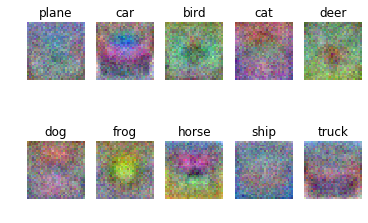

In [67]:
# Visualize the learned weights for each class.
# Depending on your choice of learning rate and regularization strength, these may
# or may not be nice to look at.
w = best_svm.W[:-1,:] # strip out the bias
w = w.reshape(32, 32, 3, 10)
w_min, w_max = np.min(w), np.max(w)
classes = ['plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
for i in range(10):
    plt.subplot(2, 5, i + 1)
      
    # Rescale the weights to be between 0 and 255
    wimg = 255.0 * (w[:, :, :, i].squeeze() - w_min) / (w_max - w_min)
    plt.imshow(wimg.astype('uint8'))
    plt.axis('off')
    plt.title(classes[i])

### Inline question 2:
Describe what your visualized SVM weights look like, and offer a brief explanation for why they look they way that they do.

**Your answer:** *fill this in*